## `Retail Store Sales` Anomaly/Outlier Detection using ML/DL Techniques 

Problem Statement:
- The dataset contains the sales data of a retail store. The task is to detect the anomalies in the sales data.

This work is inspired by https://github.com/springboard-curriculum/mec-mini-projects/blob/master/mec-16.4.1-anomaly-detection-mini-project/Mini_Project_Anomaly_Detection.ipynb

In [32]:
# necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from pyod.models import cblof
from pyod.models import auto_encoder

import git

import warnings
warnings.filterwarnings('ignore')

In [33]:
sns.set_style("darkgrid")
sns.set_palette("colorblind")

### 1. Exploratory Data Analysis (EDA)

In [34]:
basePath = git.Repo('.', search_parent_directories=True).working_tree_dir
dataPath = basePath + '/data/Superstore.csv'

In [35]:
df = pd.read_csv(dataPath)
df.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


Check for missing values

In [36]:
# check for missing values
#df.isnull().sum() # no missing values

In [37]:
# check for duplicates
#df.duplicated().sum() # no duplicates

Summary statistics

In [38]:
# summary statistics
df[['Sales', 'Quantity', 'Discount', 'Profit']].describe()

,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000
mean,229.858001,3.789574,0.156203,28.656896
std,623.245101,2.225110,0.206452,234.260108
min,0.444000,1.000000,0.000000,-6599.978000
25%,17.280000,2.000000,0.000000,1.728750
50%,54.490000,3.000000,0.200000,8.666500
75%,209.940000,5.000000,0.200000,29.364000
max,22638.480000,14.000000,0.800000,8399.976000


Sales distribution

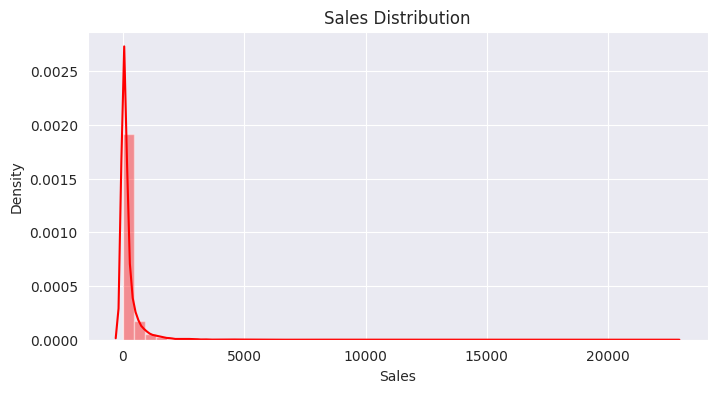

In [46]:
# Sales distribution
plt.figure(figsize=(8, 4))
sns.distplot(df['Sales'], color='r')
plt.title('Sales Distribution')
plt.show()

### 2. Univariate Anomaly Detection

Uni-variate anomaly detection is the simplest form of anomaly detection. It involves identifying outliers in a single variable. Methods:

    - Statistical Process Control (SPC) (mean+3*std threshold)
    - Isolation Forest

#### 2.1. Univariate Anomaly Detection on Sales using SPC

We will use the `3-sigma` rule to detect anomalies in the sales data. The `3-sigma` rule states that in a `normal distribution`, `99.7%` of the data falls within `three standard deviations of the mean`. Therefore, any data point that falls outside of three standard deviations from the mean can be considered an `anomaly`.

In [40]:
# Obtain upper limits for sales
mean_sales = df['Sales'].mean()
std_sales = df['Sales'].std()
three_std = 3 * std_sales   
upper_limit = mean_sales + three_std

print('Upper Limit:', upper_limit)

Upper Limit: 2099.593302356544


##### Visualize outlier region

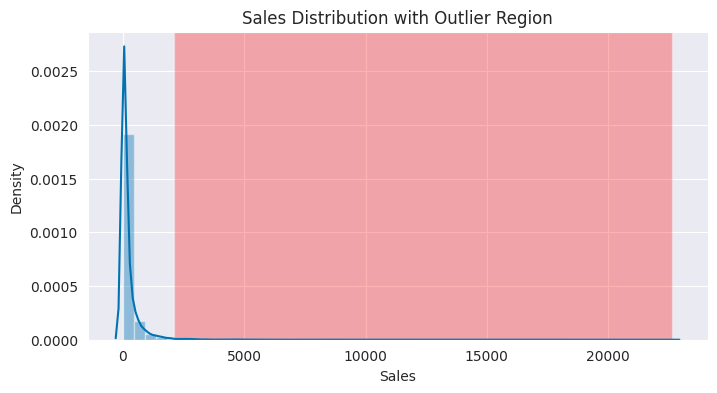

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

sns.distplot(df['Sales'])
plt.axvspan(upper_limit, df['Sales'].max(), facecolor='r', alpha=0.3)
plt.title("Sales Distribution with Outlier Region");

##### Filter out outliers

In [42]:
df_outliers = df[df['Sales'] > upper_limit]
df_outliers.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
27,28,US-2015-150630,2015-09-17,2015-09-21,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Philadelphia,...,19140,East,FUR-BO-10004834,Furniture,Bookcases,"Riverside Palais Royal Lawyers Bookcase, Royal...",3083.430,7,0.5,-1665.0522
165,166,CA-2014-139892,2014-09-08,2014-09-12,Standard Class,BM-11140,Becky Martin,Consumer,United States,San Antonio,...,78207,Central,TEC-MA-10000822,Technology,Machines,Lexmark MX611dhe Monochrome Laser Printer,8159.952,8,0.4,-1359.9920


#### 2.2. Univariate Anomaly Detection on Sales using Isoaltion Forest

`Isolation Forest` is an `unsupervised learning algorithm` that belongs to the ensemble decision trees family. It explicitly isolates anomalies instead of profiling normal data points. `Isolation Forest` is based on the Decision Tree algorithm. It isolates anomalies by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

In [43]:
from sklearn.ensemble import IsolationForest

In [44]:
iforest = IsolationForest(
    n_estimators=100, contamination=0.01, random_state=42
)

iforest.fit(df['Sales'].values.reshape(-1, 1))

IsolationForest(contamination=0.01, random_state=42)

##### Visualize outlier region

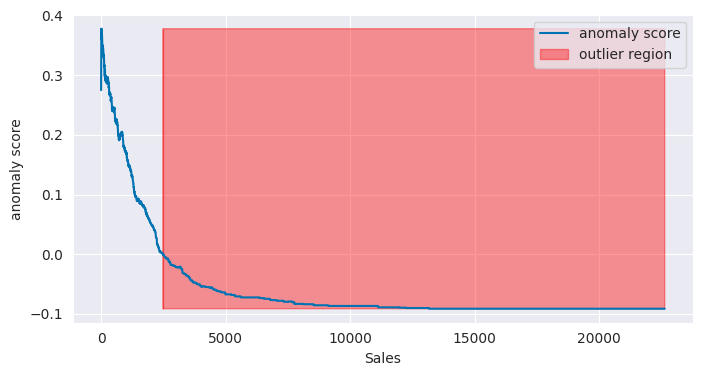

In [45]:
# Visualize the outlier region
xx = np.linspace(df['Sales'].min(), df['Sales'].max(), len(df)).reshape(-1, 1)
anomaly_score = iforest.decision_function(xx)
outlier = iforest.predict(xx)

plt.figure(figsize=(8, 4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),
                 where=outlier==-1, color='r', alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Sales')
plt.show()

### 3. Multivariate Anomaly Detection

Multivariate anomaly detection involves identifying outliers in multiple variables simultaneously. Methods:

    - Isolation Forest
    - Clustering-based Local Outlier Factor (CBLOF)
    - Autoencoder
    - DBSCAN

#### 3.1. Multivariate Anomaly Detection using Isolation Forest

Select a Subset of Features

In [16]:
target_col = ['Sales', 'Profit']
df_subset = df[target_col]

df_subset.head(2)

,Sales,Profit
0,261.96,41.9136
1,731.94,219.5820


Feauture Scaling

In [17]:
df_subset_scaled = MinMaxScaler().fit_transform(df_subset)
df_subset_scaled = pd.DataFrame(df_subset_scaled, columns=target_col)
df_subset_scaled.head(2)


,Sales,Profit
0,0.011552,0.442794
1,0.032313,0.454639


In [18]:
# Multivariate outlier detection using Isolation Forest
iforest = IsolationForest(
    n_estimators=100, contamination='auto', random_state=42
)

iforest.fit(df_subset_scaled)

outliers = iforest.predict(df_subset_scaled)

In [19]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([1203, 8791]))

In [20]:
df_outliers = df[outliers == -1]

df_outliers.head(2)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.582
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.031


#### 3.2. Multivariate Anomaly Detection using CBLOF

The CBLOF calculates the `distance` of a point `x` to its `k-nearest neighbors` and uses the `distance` to evaluate the `local density` of a point relative to its `neighbors`. It classifies the data points as `outliers` in the following way:

    - If the `average distance` of `x` to its `k-nearest neighbors` is `small`, then `x` is `normal`.
    - If the `average distance` of `x` to its `k-nearest neighbors` is `large`, then `x` is an `outlier`.


In [21]:
cblof_model = cblof.CBLOF(contamination=0.01, random_state=42)

In [22]:
cblof_model.fit(df_subset_scaled)

outliers_cblof = cblof_model.predict(df_subset_scaled)

np.unique(outliers_cblof, return_counts=True)

(array([0, 1]), array([9894,  100]))

#### 3.3. Multivariate Anomaly Detection using Autoencoder

In [25]:
ae_model = auto_encoder.AutoEncoder(hidden_neurons=[2, 32, 32, 2], 
                                    hidden_activation='relu',
                                    output_activation='sigmoid',
                                    epochs=100,
                                    batch_size=32,
                                    contamination=0.01)

In [26]:
# fit the model
ae_model.fit(df_subset_scaled)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,242 (4.85 KB)

 Trainable params: 1,242 (4.85 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 33.2127 - val_loss: 23.0690
Epoch 2/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 19.0826 - val_loss: 18.0778
Epoch 3/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12.3267 - val_loss: 13.8407
Epoch 4/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.3600 - val_loss: 10.9652
Epoch 5/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8358 - val_loss: 9.1844
Epoch 6/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.9047 - val_loss: 7.5966
Epoch 7/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6371 - val_loss: 6.5137
Epoch 8/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1609 - val_loss: 5.6411
Epoch 9/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.5113 - val_loss: 4.9279
Epoch 10/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.6170 - val_loss: 4.3450
Epoch 11/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.4821 - val_loss: 3.9148
Epoch 12/100
282/282 ━━━━━━━━

AutoEncoder(batch_size=32, contamination=0.01, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[2, 32, 32, 2],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7724c346be20>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [29]:
# get the prediction labels
outliers_ae = ae_model.predict(df_subset_scaled)

np.unique(outliers_ae, return_counts=True)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step


(array([0, 1]), array([9894,  100]))

### 4. Conclusion

In this notebook, we have implemented various anomaly detection techniques to detect anomalies in the sales data of a retail store. We have used both univariate and multivariate anomaly detection techniques to detect anomalies in the sales data.